### Preparation - Review raw usage data

In [16]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

import plot_helper as ph
import data_helper as dh

CSV_FILES = [
    '../data/GlobalUsageReport_05-17-2018.csv'
#    '../data/GlobalUsageReport_02-22-2018.csv'
]

DF = dh.load_files(CSV_FILES)

DF = DF[(DF['Product Family'] == 'Rental') &
          (DF['Collection Status'].isin(['Closed','Pending Agg','Pending Vendor']))]   

Start reading ../data/GlobalUsageReport_05-17-2018.csv... 126,484 records found


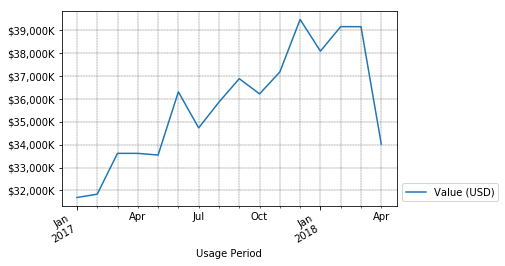

In [17]:
ph.plot_trend_chart(DF)
plt.show()

### Preparation - Configure QUARTER_RANGE in defines.py

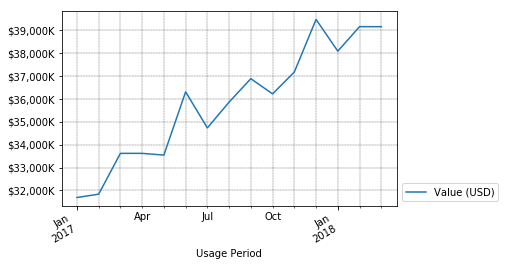

In [18]:
from defines import *

DF = DF[(DF['Usage Period']<=END_MONTH) & (DF['Usage Period']>=START_MONTH)]

ph.plot_trend_chart(DF)

### Total VCPP Revenue & Parnter Count Trend

YoY Partner Count Growth: +3%
YoY Quarterly Revenue Growth : +20%


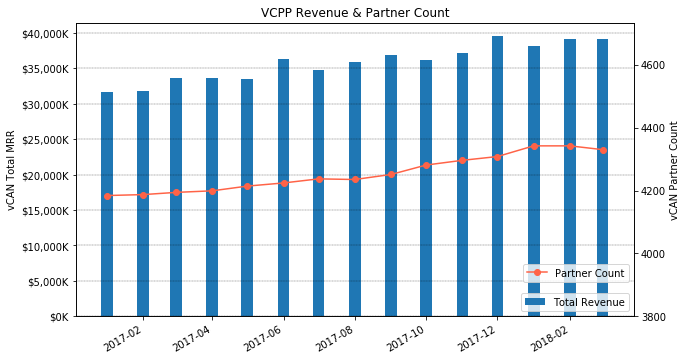

In [21]:
ph.plot_vcpp_trend(DF)


### Partner Group Name Correction

In [28]:
DF.loc[DF['Service Provider'].str.match(r'.*Softlayer*'),'Partner Group Name'] = 'IBM'
DF.loc[DF['Service Provider'].str.match(r'.*Softlayer*'),'Partner Status'] = 'Showcase'

### Showcase Partner Growth Trend

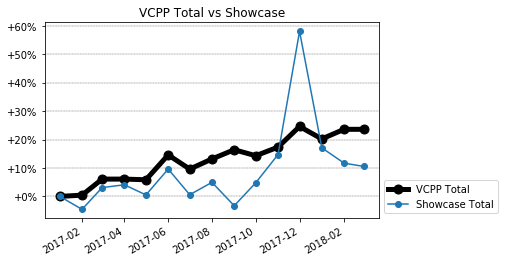

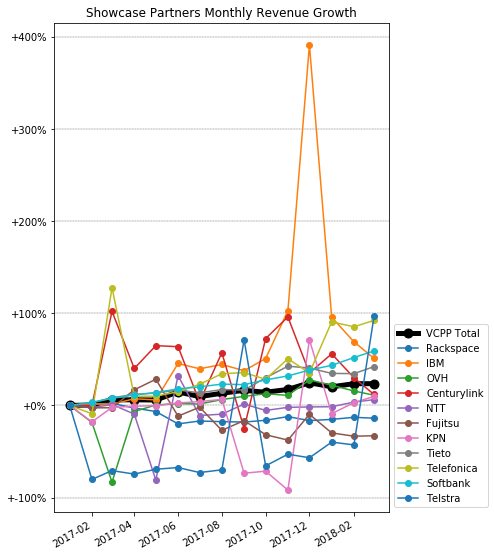

In [49]:
def plot_rev_trend(l,data,thick=False):
    if thick:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l,linewidth=5.0,markersize=9.0,color='#000000')
    else:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l)

def plot_partner(partner):
    plot_rev_trend(partner,DF[DF['Partner Group Name']==partner].groupby('Usage Period')['Value (USD)'].sum())

def format_chart(title):
    ax = ph.format_trend_chart()
    ax.set_yticklabels(['+{:,.0f}%'.format(x) for x in ax.get_yticks()])
#    ax.legend(loc="lower right", bbox_to_anchor=(1,0))
    plt.title(title)

plot_rev_trend('VCPP Total',DF.groupby('Usage Period')['Value (USD)'].sum(),True)
plot_rev_trend('Showcase Total',DF[DF['Partner Status']=='Showcase'].groupby('Usage Period')['Value (USD)'].sum())
format_chart('VCPP Total vs Showcase')
plt.show()

plot_rev_trend('VCPP Total',DF.groupby('Usage Period')['Value (USD)'].sum(),True)
for sp in showcase_partners.index:
    plot_partner(sp) 
format_chart("Showcase Partners Monthly Revenue Growth")
plt.gcf().set_size_inches(6,10)
plt.show()


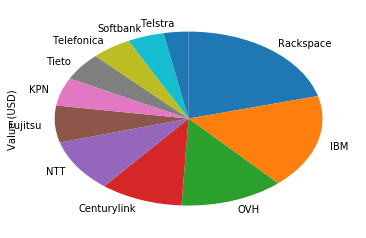

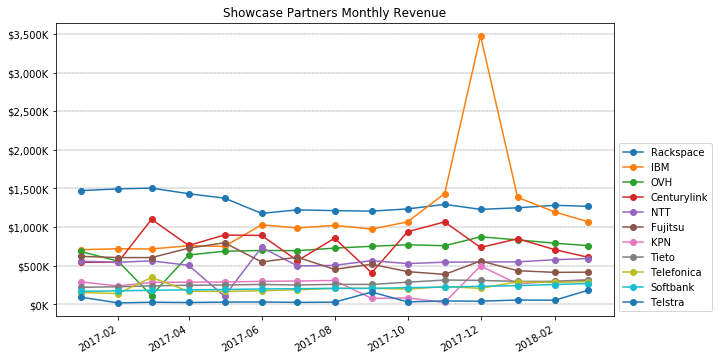

In [30]:
showcase_partners = DF[(DF['Usage Period'] == END_MONTH) &
                       (DF['Partner Status'] == 'Showcase')].groupby('Partner Group Name')['Value (USD)'].sum().sort_values(ascending=False)

showcase_partners.plot.pie(startangle=90,counterclock=False)
plt.show()

for partner in showcase_partners.index:
    partner_rev = DF[DF['Partner Group Name'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    plt.plot(partner_rev.index,partner_rev.values,'o-',label=partner)

ph.format_trend_chart()

plt.title("Showcase Partners Monthly Revenue")
plt.gcf().set_size_inches(10,6)
plt.show()

### Revenue Growth

In [29]:
from scipy.optimize import curve_fit

def fn_rev_growth(x,a,b):
    return b*a**x

def calc_growth_rate(df,alpha=0.5,plot=False,fit=True):
    df = df[['Usage Period','Value (USD)']].groupby(['Usage Period']).sum().reset_index()

    month_ago_rev = df['Value (USD)'].shift(1)
    mom_growth = (df['Value (USD)'] - month_ago_rev)/month_ago_rev
    mom_growth_dev = abs((mom_growth - mom_growth.mean())/mom_growth.std())
    
    popt = [.0,.0]
    if fit:
        popt, pcov = curve_fit(fn_rev_growth,df.index[mom_growth_dev<alpha],df[mom_growth_dev<alpha]['Value (USD)'])

    if plot:
        plt.bar(df['Usage Period'],df['Value (USD)'],10)
        if fit:
            plt.plot(df['Usage Period'],fn_rev_growth(df.index,popt[0],popt[1]))
        fig = plt.gcf()
        fig.autofmt_xdate() 
        plt.show()   

    return popt

### Top 10 Service Providers

,Service Provider,Last Month Revenue,MoM Revenue Growth,Base Revenue,Next Month Revenue Increase
0,"Rackspace US, Inc",906424.20,0.997261,1.023866e+06,-2482.847670
1,"Softlayer Technologies, Inc.",740831.39,1.096049,7.055152e+04,71155.810016
2,OVH,646488.30,1.038304,2.934921e+05,24762.989190
3,SAVVIS,608877.72,1.046250,3.580072e+05,28160.481433
4,Hewlett-Packard Enterprise Company,589087.13,1.085889,8.082404e+04,50596.220149
5,OVH US,444008.72,1.229196,1.491777e+05,101764.963455
6,Internet Initiative Japan Inc.,418513.87,1.014055,2.892752e+05,5882.285806
7,NTT Communications Corporation,318433.86,1.000011,3.361592e+05,3.508106
8,Rackspace Ltd,314261.20,0.998170,3.125903e+05,-575.189831
9,Tieto Corporation,312083.12,1.010601,2.208827e+05,3308.272344


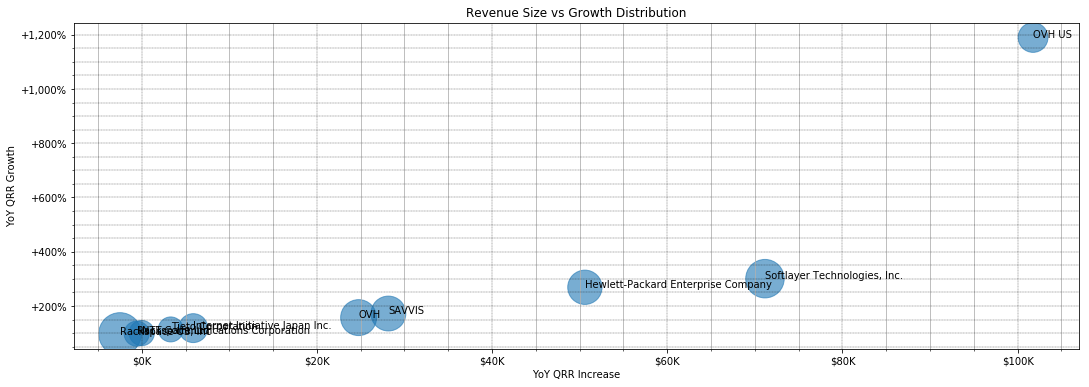

In [13]:
DF_EQ = DF[(DF['Usage Period']<=END_QUARTER[2]) & (DF['Usage Period']>=END_QUARTER[0])]

def plot_size_growth_by(key):
    s_top10 = DF[DF['Usage Period']==END_MONTH].groupby(key)['Value (USD)'].sum().sort_values(ascending=False)[:10]
    
    d = dict.fromkeys(['Service Provider','Last Month Revenue','MoM Revenue Growth','Base Revenue','Next Month Revenue Increase'])
    df_top10 = pd.DataFrame(columns=d.keys())
    for sp in s_top10.index:
        growth, base = calc_growth_rate(DF[DF['Service Provider']==sp])
        d['Service Provider'] = sp
        d['Last Month Revenue'] = s_top10[sp]
        d['MoM Revenue Growth'] = growth
        d['Base Revenue'] = base
        d['Next Month Revenue Increase'] = s_top10[sp]*(growth-1)
        df_top10 = df_top10.append(d,ignore_index=True)
 
    display(df_top10)
        
    ph.plot_size_growth(df_top10['Service Provider'].values,
                        df_top10['Next Month Revenue Increase'].values,
                        df_top10['MoM Revenue Growth'].values**12*100,
                        df_top10['Last Month Revenue'].values)
    
plot_size_growth_by('Service Provider')
#plot_size_growth_by('Partner Group Name')

### Showcase Partner Growth Leader

IBM                                      United States    (AMER) $ 1,505,995 (70%)
OVH                                      France           (EMEA) $ 1,029,902 (76%)
NTT                                      Japan            (APAC) $    55,096 (3%)
Tieto                                    Finland          (EMEA) $   220,792 (32%)
KPN                                      Netherlands      (EMEA) $    68,950 (8%)
Telefonica                               Spain            (EMEA) $   228,892 (36%)
Softbank                                 Japan            (APAC) $   242,279 (46%)
Telstra                                  Australia        (APAC) $   153,288 (111%)


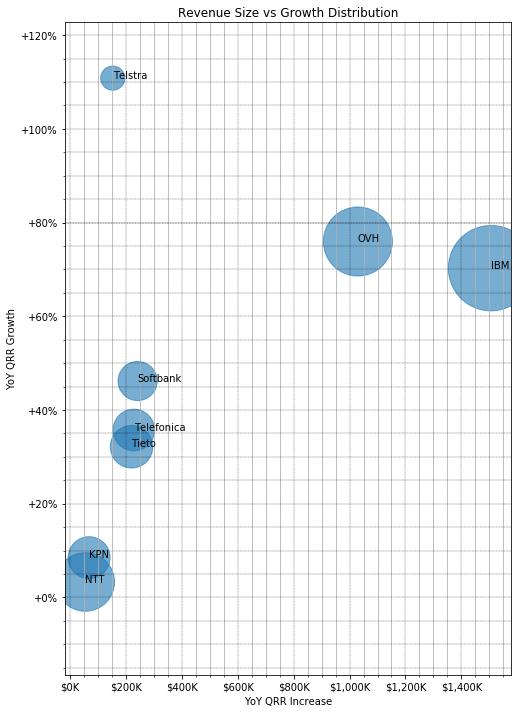

In [44]:
import size_vs_growth as sg
    
sg.plot(DF[(DF['Partner Status']=='Showcase')],
    {'type':['NO_SLICE'],
     'min_rev_growth':200,
    'show_sp_name':200},group_key='Partner Group Name')

### VCPP Partners Revenue Distribution

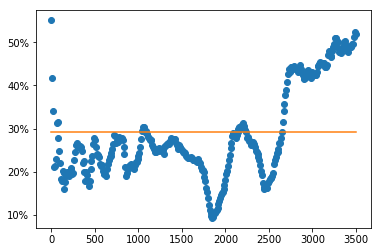

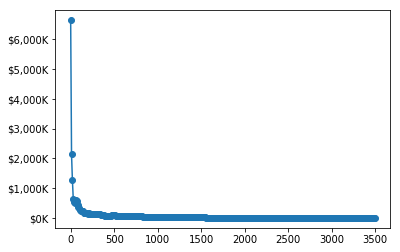

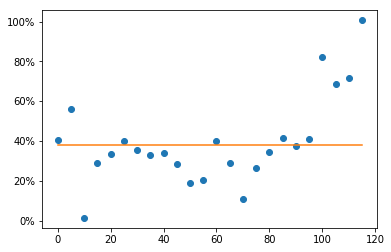

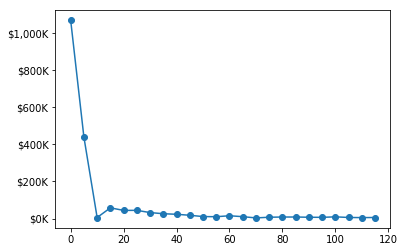

In [6]:
def df_quarter(_df,q):
    return _df[(_df['Usage Period']>=q[0])&(_df['Usage Period']<=q[2])]

def build_rank_df(df,step=100):
    s_last_sp_rev = df_quarter(df,END_QUARTER).groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    s_prev_sp_rev = df_quarter(df,YEAR_AGO_QUARTER).groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

    df_rank = pd.DataFrame(columns=['rank_start','rank_stop','rev_prev','rev_last','increase_rate','increase_value'])

    for r in range(0,len(s_last_sp_rev),step):
        start, stop = r, r+step
        last = s_last_sp_rev[start:stop].sum()
        prev = s_prev_sp_rev[start:stop].sum()
        growth_rate = (last/prev-1.0)*100
        
        if prev <= step*1000:
            break
        df_rank.loc[start] = [start,stop,prev,last,growth_rate,last-prev]
            
    return df_rank

def plot_rank_df(df_rank):
    total_growth_rate = (df_rank.rev_last.sum()/df_rank.rev_prev.sum()-1)*100
    plt.plot(df_rank.index,df_rank.increase_rate,'o')
    plt.plot(df_rank.index,np.ones_like(df_rank.index)*total_growth_rate,'-')    
    ax = plt.gca()
    ax.set_yticklabels(['{:.0f}%'.format(y) for y in ax.get_yticks()])
    plt.show()

    plt.plot(df_rank.index,df_rank.increase_value,'o-')
    ax = plt.gca()
    ax.set_yticklabels(['${:,.0f}K'.format(y/1000) for y in ax.get_yticks()])
    plt.show()

plot_rank_df(build_rank_df(DF,step=10))
plot_rank_df(build_rank_df(DF[DF['Country'] == 'Japan'],step=5))


### Showcase Partner - Group Companies Revenue Trend

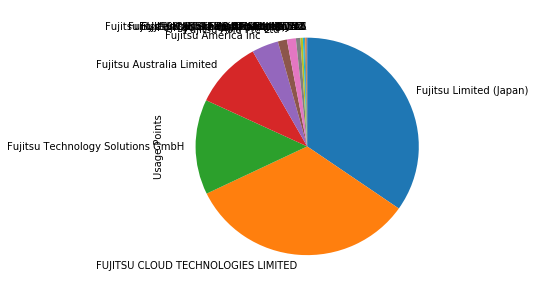

Total VM Count: 22,077,091


Service Provider | GEO | Ratio | VM Count
:---|---|---|---
Fujitsu Limited (Japan)|APAC|34.7 %|524,146
FUJITSU CLOUD TECHNOLOGIES LIMITED|APAC|33.2 %|590,860
Fujitsu Technology Solutions GmbH|EMEA|14.1 %|80,824
Fujitsu Australia Limited|APAC|9.9 %|0
Fujitsu America Inc|AMER|3.9 %|0
Fujitsu Asia Pte Ltd|APAC|1.3 %|19,936
FUJITSU FIP CORPORATION|APAC|1.3 %|0
FUJITSU DO BRASIL LTDA|AMER|0.6 %|10,780
Fujitsu Caribbean (Trinidad) Ltd.|AMER|0.4 %|6,314
FUJITSU SYSTEMS WEST LIMITED|APAC|0.2 %|3,136
Fujitsu NZ|APAC|0.1 %|0
Fujitsu Kagoshima Infornet LIMITED|APAC|0.1 %|1,925
Fujitsu Norway AS|EMEA|0.1 %|1,715
Fujitsu Vietnam Ltd|APAC|0.1 %|430
Fujitsu Systems Business (Thailand) Ltd.|APAC|0.0 %|0

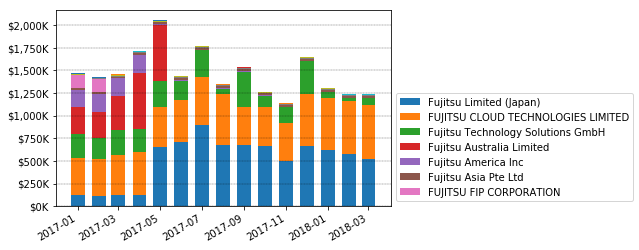

Service Provider | Bundle - SDDC|NSX|Bundle - Horizon|SRM|vRealize Automation|vSAN|vCloud Availability|vRealize Operations|vRealize Business|vRealize Network Insight|VSPP|PrePay
---|---|---|---|---|---|---|---|---|---|---|---|---
Fujitsu Limited (Japan)|\$ 4,958,833|\$ 2,000|\$ 2,648,525|\$ 28,872|\$ 90|\$ 16,454||\$ 660||||
FUJITSU CLOUD TECHNOLOGIES LIMITED|\$ 3,907,200|\$ 3,370,350|\$ 36,000||||\$ 10,365|||||
Fujitsu Technology Solutions GmbH|\$ 2,780,429||\$ 111,817|\$ 186,073|\$ 33,270|||\$ 7,106||||
Fujitsu Australia Limited|\$ 2,184,963|||\$ 4,608||||||||
Fujitsu America Inc|\$ 854,895|||||||||||
Fujitsu Asia Pte Ltd|\$ 289,213||||||||\$ 6|\$ 3||
FUJITSU FIP CORPORATION|\$ 287,583|||||||||||
FUJITSU DO BRASIL LTDA|\$ 141,960|||||||||||
Fujitsu Caribbean (Trinidad) Ltd.|\$ 77,926|||||||||||
FUJITSU SYSTEMS WEST LIMITED|\$ 43,967|||||||||||
Fujitsu NZ|\$ 32,641|||||||||||
Fujitsu Kagoshima Infornet LIMITED|\$ 25,333|||||||||||
Fujitsu Norway AS|\$ 14,847|||||||||||
Fujitsu Vietnam Ltd|\$ 12,940|||||||||||
Fujitsu Systems Business (Thailand) Ltd.|\$ 8,162|||||||||||

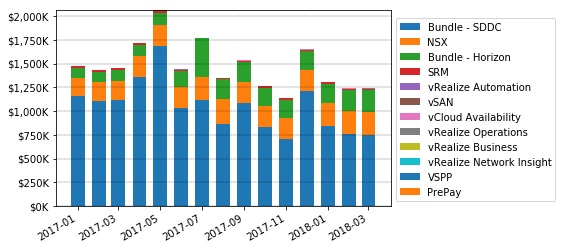

In [65]:
from IPython.display import HTML, Markdown, display
from plot_helper import *


def plot_pie(series):
    series.plot.pie(startangle=90,counterclock=False)
    plt.gcf().set_size_inches(5,5)
    plt.show()      

def partner_snapshot(df_pg,key='Value (USD)',product_key='Product Group'):
    # sorted list by "key" size
#    s_pg_sorted = df_pg[df_pg['Usage Period'] == END_MONTH].groupby('Service Provider')[key].sum().sort_values(ascending=False)
    s_pg_sorted = df_pg.groupby('Service Provider')[key].sum().sort_values(ascending=False)
 
    # index list of entire usage period
    i_up = df_pg.groupby('Usage Period')[key].sum().index

    # revenue distritbution pie chart
    plot_pie(s_pg_sorted)
   
    total_rev = s_pg_sorted.sum()
    print("Total VM Count: {:,.0f}".format(total_rev))
    prev_bar = 0
    rows = []
    for sp,rev in s_pg_sorted.items():
        df_sp = df_pg[df_pg['Service Provider'] == sp]
        sp_label = sp if rev/total_rev > 0.01 else ''
 
        rev_by_period = df_sp.groupby('Usage Period')[key].sum() 
        for up in i_up:
            if not up in rev_by_period.keys():
                rev_by_period.at[up] = 0.0
        rev_by_period = rev_by_period.sort_index()
        rows.append([sp,df_sp['GEO'].iloc[0],
                     '{:.1f} %'.format(rev/total_rev*100),
                     '{:,.0f}'.format(rev_by_period.at[END_MONTH])])
 
        plt.bar(rev_by_period.index,rev_by_period.values,width=20,label=sp_label,bottom=prev_bar)
        prev_bar += rev_by_period.values
        
    display(Markdown("\n".join(['Service Provider | GEO | Ratio | VM Count',
                                ':---|---|---|---',
                                "\n".join(map(lambda row: '|'.join(row),rows))])))   
    format_trend_chart()
    plt.show()  
    
    s_prod_sorted = df_pg.groupby(product_key)[key].sum().sort_values(ascending=False)

    prev_bar = 0
    for prod,rev in s_prod_sorted.items():
        rev_by_up = df_pg[df_pg[product_key]==prod].groupby('Usage Period')[key].sum()    
        for up in i_up:
            if not up in rev_by_up.keys():
                rev_by_up.at[up] = 0.0
        rev_by_up = rev_by_up.sort_index()
            
        plt.bar(rev_by_up.index,rev_by_up.values,width=20,label=prod,bottom=prev_bar)
        prev_bar += rev_by_up.values
    
    rows = []
    for sp in s_pg_sorted.keys():
        row = [sp]
        for prod in s_prod_sorted.keys():
            rev = df_pg[(df_pg['Service Provider'] == sp)&(df_pg[product_key] == prod)][key].sum()
            row.append('' if rev==0.0 else '\$ {:,.0f}'.format(rev))
        rows.append('|'.join(row))   
 
    display(Markdown("\n".join(['Service Provider | {}'.format('|'.join(s_prod_sorted.index)),
                                '|'.join(['---'] * (1+len(s_prod_sorted)))] + rows)))
    
#    df_heatmap = pd.DataFrame(index=s_pg_sorted.keys(),columns=s_prod_sorted.keys())
#    for sp in s_pg_sorted.keys():
#        for prod in s_prod_sorted.keys():
#            rev = df_pg[(df_pg['Service Provider'] == sp)&(df_pg['Product Group'] == prod)][key].sum()
#            df_heatmap.loc[sp][prod] = '' if rev==.0 else '$ {:,.0f}'.format(rev)

    
    format_trend_chart()
    plt.show()

#partner_snapshot(DF[DF['Partner Group Name'] == 'NTT'])

#partner_snapshot(DF[DF['Service Provider'].str.match(r'.*Dimension Data*')],key='Value (USD)')

#for pg in df_top10.sort_values(by=['Revenue'],ascending=False)['Partner Group Name'].unique():
#    partner_snapshot(df[df['Partner Group Name'] == pg])
partner_snapshot(DF[DF['Partner Group Name'] == 'Fujitsu'],key='Usage Points')
#partner_snapshot(DF[(DF['Partner Group Name'] == 'IBM')],key='Value (USD)')
#partner_snapshot(DF[(DF['Partner Group Name'] == 'NTT') & (DF['Service Provider'] != 'NTT Communications Corporation')])
#partner_snapshot(df[df['Service Provider'].str.match('itelligence')])

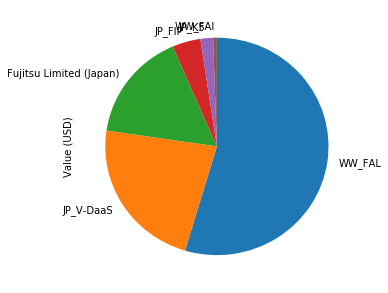

In [63]:
plot_pie(DF[DF['Service Provider']=='Fujitsu Limited (Japan)'].groupby('Site Name')['Value (USD)'].sum().sort_values(ascending=False))

NTT SMARTCONNECT Corporation             Japan            (APAC) $     9,429 (20%)
NTT Com Asia Limited                     Hong Kong        (APAC) $     4,132 (12%)
NTT NEOMEIT Corporation                  Japan            (APAC) $    26,647 (2,869%)
NTT Communications (Thailand) Co.,Ltd.   Thailand         (APAC) $     9,434 (108%)
NTT Communications Russia                Russian Federation (EMEA) $     6,213 (167%)
NTTPC Communications,Inc.                Japan            (APAC) $     1,941 (207%)
NTT BizLink, Inc.                        Japan            (APAC) $       908 (57%)
NTT DATA CORPORATION                     Japan            (APAC) $     1,537 (166%)
NTT DATA KYUSHU Corporation              Japan            (APAC) $       215 (17%)


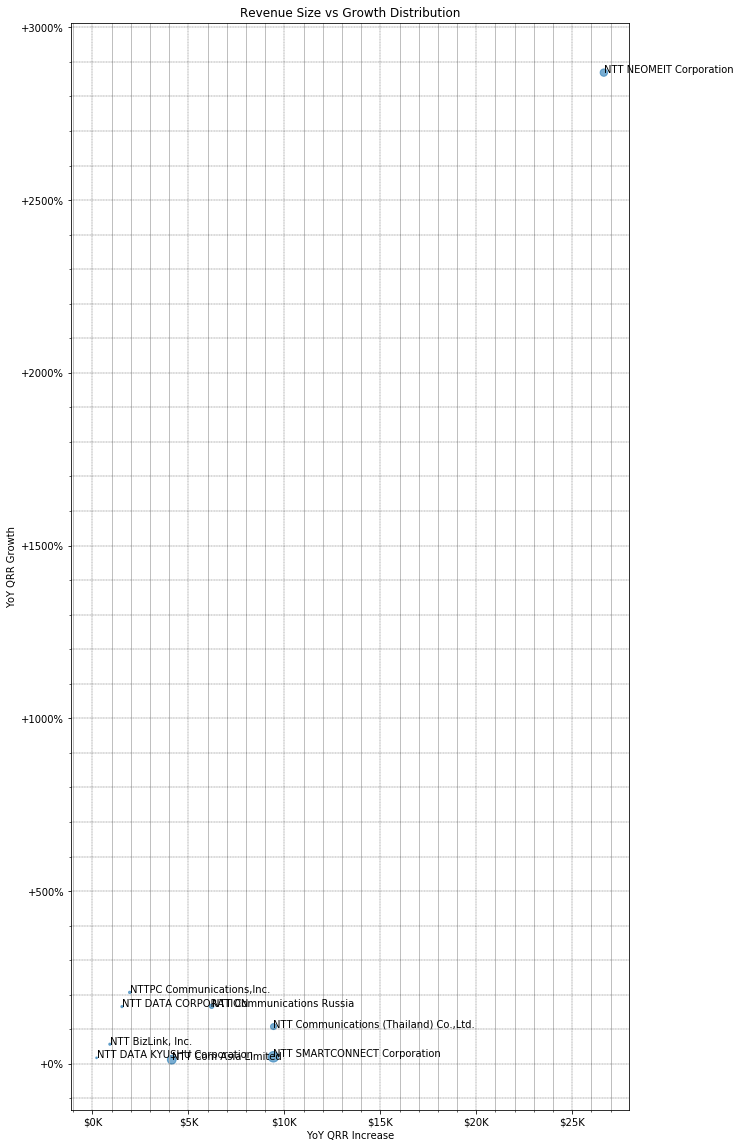

In [20]:
import size_vs_growth as sg

sg.plot(df[(df['Partner Group Name']=='NTT')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':50,
    'show_sp_name':50})

### Revenue Size vs Growth

Internet Initiative Japan Inc.           Japan            (APAC) $   288,399 (33%)
NTT Communications Corporation           Japan            (APAC) $   100,874 (12%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   410,105 (292%)
IDC Frontier Inc.                        Japan            (APAC) $    53,286 (12%)
SoftBank Corp.                           Japan            (APAC) $   214,544 (126%)
NEC Corporation                          Japan            (APAC) $   214,523 (448%)
CTC/ITOCHU Techno-Solutions Corp         Japan            (APAC) $    83,245 (61%)
NS Solutions Corporation                 Japan            (APAC) $   132,893 (197%)
SCSK Corporation                         Japan            (APAC) $    34,526 (29%)
I-NET CORP.                              Japan            (APAC) $    41,872 (54%)
FreeBit Co.,Ltd.                         Japan            (APAC) $    83,769 (1,130%)
Uniadex ltd.                             Japan            (APAC) $    66,445 (2,

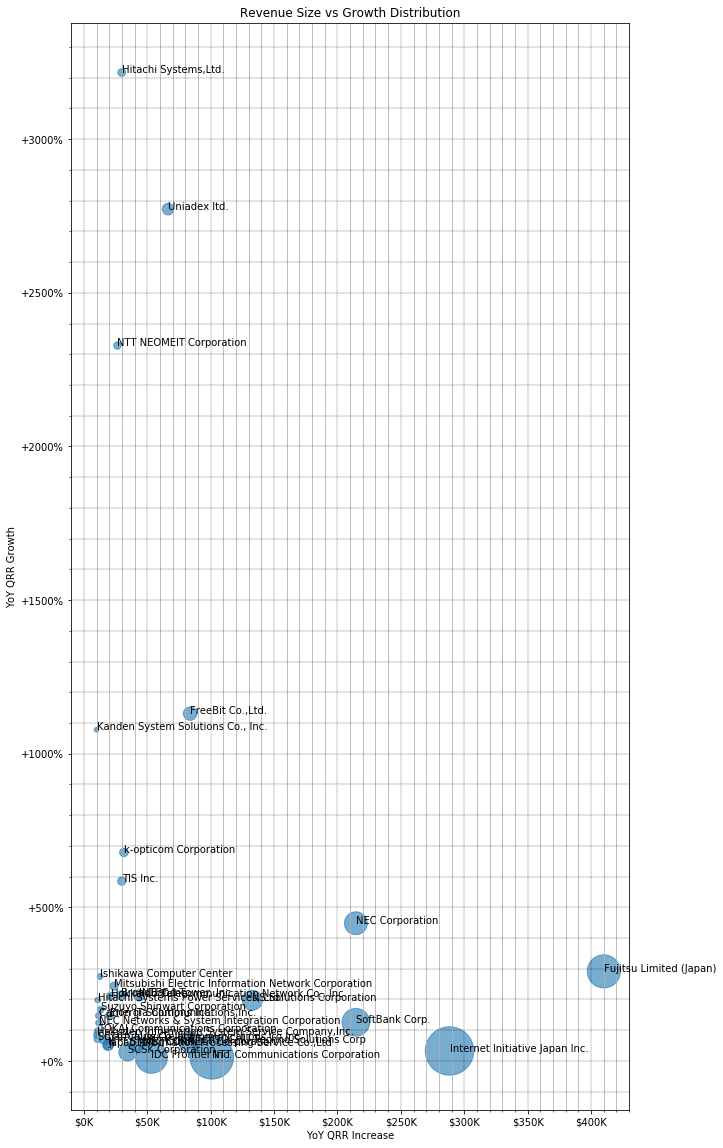

In [9]:
import size_vs_growth as sg

#sg.plot(df,
#     {'type':['GEO','RANK'],
#      'time_frame': 'LAST_12',
#      'min_rev_growth':10000,
#      'show_sp_name':500000})
    
sg.plot(DF[(DF['Country']=='Japan')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':10000,
    'show_sp_name':10000})

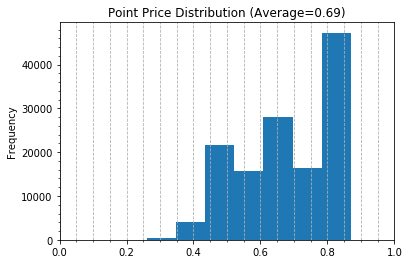

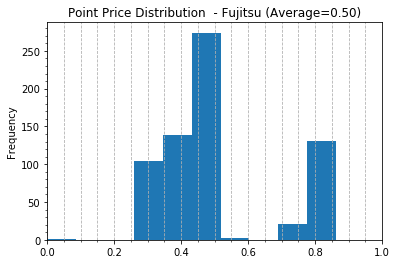

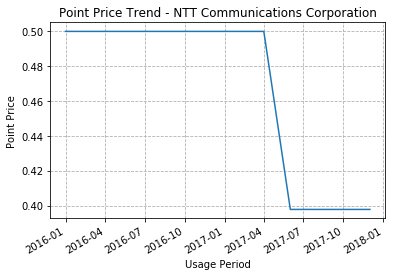

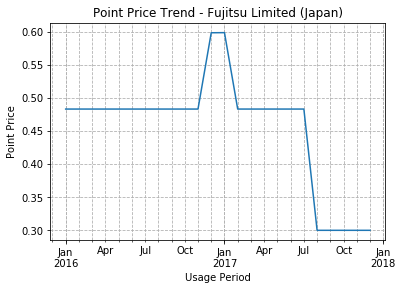

In [14]:
def plot_dist(d,caption=''):
    pp = d['Value (USD)']/d['Usage Points']

    pp.plot.hist(bins=10)
    plt.minorticks_on()
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.xlim([0,1.0])
    plt.title("Point Price Distribution {}(Average={:.2f})".format(caption,pp.mean()))
    plt.show()

_df = df[df['Usage Points'] > 0]
_df_fujitsu = _df[_df['Partner Group Name']=='Fujitsu'].copy()

plot_dist(_df)
plot_dist(_df_fujitsu,caption=' - Fujitsu ')

def point_price_trend(sp):
    _df_sp = _df[_df['Service Provider']==sp].copy()
#    _df_sp = _df[_df['Partner Group Name']==sp].copy()
    _df_sp.loc[:,'Point Price'] = pd.Series(_df_sp['Value (USD)']/_df_sp['Usage Points'],index=_df_sp.index)

    _df_sp.groupby('Usage Period')['Point Price'].max().plot()
    plt.ylabel('Point Price')
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.gca().yaxis.grid(True, which='both',linestyle='dashed')
    plt.title('Point Price Trend - {}'.format(sp))
    plt.show()
    

point_price_trend('NTT Communications Corporation')
point_price_trend('Fujitsu Limited (Japan)')





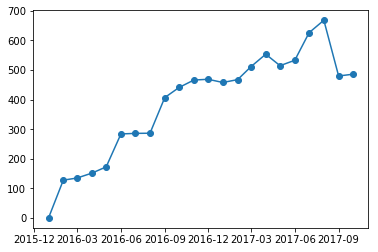

In [222]:
s_nifty = df[(df['Service Provider'].str.match(r'.*FUJITSU CLOUD.*')) | (df['Service Provider'].str.match(r'.*NIFTY.*'))].groupby('Usage Period')['Value (USD)'].sum()

start = s_nifty.values[0]

plt.plot(s_nifty.index,(s_nifty.values/start-1)*100,'o-',label='Nifty Revenue')
#format_trend_chart()
plt.show()

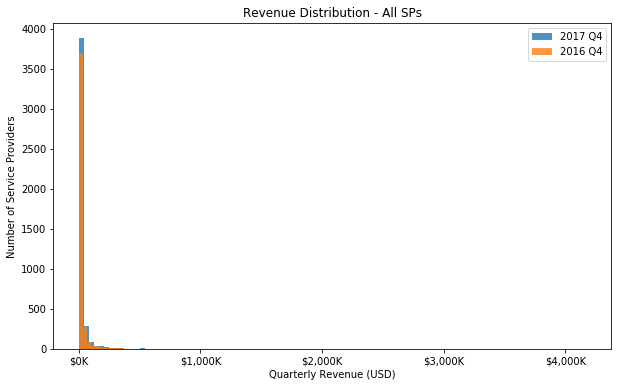

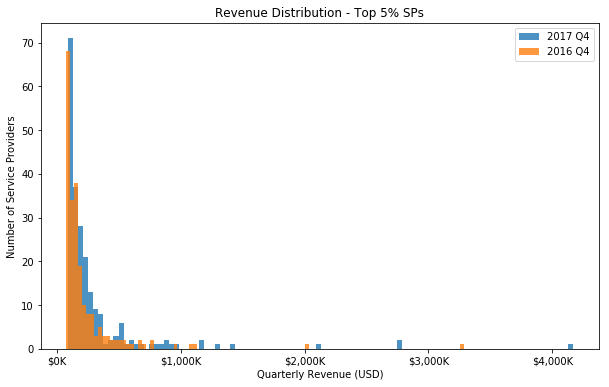

Total SP Count: 4399
Top 10 SPs Contribution: 16%
Softlayer Technologies, Inc.         4,170,429
Rackspace US, Inc                    2,765,411
SAVVIS                               2,742,297
OVH                                  2,095,654
Hewlett-Packard Enterprise Company   1,399,676
IBM                                  1,292,668
Canopy the Open Cloud Company        1,182,148
Internet Initiative Japan Inc.       1,175,218
NTT Communications Corporation       951,097
Tieto Corporation                    907,637


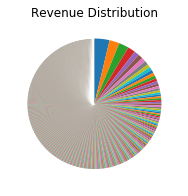

Total SP Count: 150
Top 10 SPs Contribution: 72%
Internet Initiative Japan Inc.       1,175,218
NTT Communications Corporation       951,097
Fujitsu Limited (Japan)              550,763
IDC Frontier Inc.                    510,839
FUJITSU CLOUD TECHNOLOGIES LIMITED   510,644
SoftBank Corp.                       385,005
NEC Corporation                      262,391
CTC/ITOCHU Techno-Solutions Corp     219,871
NS Solutions Corporation             200,217
SCSK Corporation                     155,193


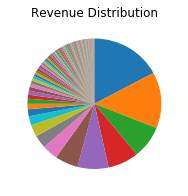

In [91]:
def df_quarter(df,Q):
    return df[(df['Usage Period'] >= Q[0]) & (df['Usage Period'] <= Q[2])]

def plot_hist(data_prev,data_last,cutoff,title):
    plt.hist(data_last[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2017 Q4')
    plt.hist(data_prev[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2016 Q4')

    plt.xlabel("Quarterly Revenue (USD)")
    plt.ylabel("Number of Service Providers")
    plt.title(title)
    ax = plt.gca()
    fig = plt.gcf()
    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.legend(loc="upper right")
    fig.set_size_inches(10,6)
    plt.show()
    
df_last_q = df_quarter(df,END_QUARTER)
df_prev_q = df_quarter(df,YEAR_AGO_QUARTER)
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    
plot_hist(data_prev,data_last,1.0,"Revenue Distribution - All SPs")
plot_hist(data_prev,data_last,0.05,"Revenue Distribution - Top 5% SPs")
    
def print_pie(df):
    total_last = df['Value (USD)'].sum()
    s_sp_val = df.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    print("Total SP Count: {}".format(len(s_sp_val)))
    print("Top {} SPs Contribution: {:.0f}%".format(10,s_sp_val[:10].sum()/total_last*100))
    for sp,val in s_sp_val[:10].iteritems():
        print("{:36s} {:,.0f}".format(sp,val))
    
    plt.pie(s_sp_val.values,startangle=90,counterclock=False)
    plt.title('Revenue Distribution')
    plt.gcf().set_size_inches(3,3)
    plt.show()

print_pie(df_last_q)
print_pie(df_last_q[df_last_q['Country'] == 'Japan'])



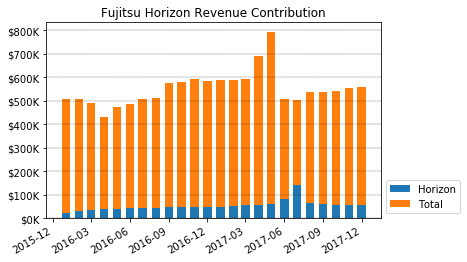

In [7]:
df_f = df[df['Partner Group Name']=='Fujitsu']
df_f_h = df_f[df_f['Product'].str.match(r'.*Horizon.*')]

total = df_f.groupby('Usage Period')['Value (USD)'].sum()
horizon = df_f_h.groupby('Usage Period')['Value (USD)'].sum()

plt.bar(total.index,horizon.values,20,label='Horizon')
plt.bar(total.index,total.values-horizon.values,20,label='Total',bottom=horizon.values)

format_trend_chart()
plt.title('Fujitsu Horizon Revenue Contribution')
plt.show()
    
#(df['Product Group']=='Horizon']


In [8]:
df_ops_map = pd.read_csv("../data/LeeMap.csv",encoding="ISO-8859-1")
df_ops_map = pd.read_csv("../data/AggregatorMap.csv",encoding="ISO-8859-1")
df_ops_map = pd.read_csv("../data/MBO_Rev_Data_Apr2018.csv")

groupnames = [
    'NTT',
    'Fujitsu',
    ['FUJITSU','Fujitsu'],
    'Rackspace',
    'Virtustream',
    'IBM',
    ['SoftLayer','IBM'],
    ['Softlayer','IBM'],    
    'Tieto',
    'OVH',
    'KPN',
    ['Kpn','KPN'],
    ['SAVVIS','CenturyLink']
]

for g in groupnames:
    pat,group = None,None
    if isinstance(g,list):
        pat,group = g
    else:
        pat,group = g,g
    df_ops_map.loc[df_ops_map['reseller'].str.match(r'.*{}.*'.format(pat)),'Partner Group Name'] = group

In [11]:


# df_group_map = pd.read_csv("../data/GroupMap.csv",encoding="ISO-8859-1")
df_last_q = df[(df['Usage Period']>=END_QUARTER[0]) & (df['Usage Period']<=END_QUARTER[2])]

ntt_groups = {
#    'ops': set(df_ops_map[df_ops_map['Global Ultimate Name match']=='NTT']['Reseller in Bookings']),
    'ops': set(df_ops_map[df_ops_map['Partner Group Name']=='NTT']['reseller']),
#    'entity_map': set(df_group_map[df_group_map['Partner Group Name']=='NTT']['Enduserorganization']),
    'usage_data': set(df_last_q[df_last_q['Partner Group Name']=='NTT']['Service Provider'])
}

fujitsu_groups = {
#    'ops': set(df_ops_map[df_ops_map['Global Ultimate Name match']=='Fujitsu']['Reseller in Bookings']),
#    'entity_map': set(df_group_map[df_group_map['Partner Group Name']=='NTT']['Enduserorganization']),
    'usage_data': set(df_last_q[df_last_q['Partner Group Name']=='Fujitsu']['Service Provider'])
}

from functools import reduce

total_rev = 0
for sp in sorted(reduce(lambda g0, g1: g0.union(g1), ntt_groups.values())):
    rev = df_last_q[df_last_q['Service Provider']==sp]['Value (USD)'].sum()
#    if rev == 0:
#        continue
    if sp in ntt_groups['usage_data'] and sp in ntt_groups['ops']:
        continue
    total_rev += rev
#    if sp in ntt_groups['ops']:
#        continue
       
    print('{:64s}: {} {} : {:10,.2f}'.format(sp,
                                        '*' if sp in ntt_groups['usage_data'] else ' ',
                                        '*' if sp in ntt_groups['ops'] else ' ',
                                         df_last_q[df_last_q['Service Provider']==sp]['Value (USD)'].sum()
                                    ))

print('{:,.2f}'.format(total_rev))
    
    

NTT Communications China Co., Ltd.                              :   * :   1,436.55
NTT DATA INC                                                    :   * :       0.00
NTT DATA ITALIA SPA	                                            :   * :       0.00
NTT DATA Inc.                                                   :   * :       0.00
NTT EUROPE ONLINE GMBH                                          :   * :       0.00
NTT Europe Online GmbH                                          : *   :  10,991.29
NTT Indonesia                                                   : *   :   1,047.60
NTT Singapore PTE Ltd                                           :   * :       0.00
NTT Singapore Pte Ltd                                           : *   :  22,657.60
PT. NTT Indonesia                                               :   * :       0.00
36,133.04


In [ ]:
# original list from Roger
ntt_groups = {
    'ops': {
        'Ingram Micro (China) Limited',
        'Insight (Software Spectrum)',
        'INSIGHT DIRECT USA, INC.',
        'Insight Techn. Solutions GmbH',
        'Networld Corp.',
        'NTT America',
        'NTT America, Inc. SME',
        'NTT Australia Pty Ltd',
        'NTT BizLink, Inc.',
        'NTT Com Asia Limited',
        'NTT Com ICT Solutions (Australia) Pty Ltd',
        'NTT Communications (Thailand) Co.,Ltd.',
        'NTT Communications China Co., Ltd.',
        'NTT Communications Corporation',
        'NTT Communications Corporation Australia Office',
        'NTT Communications Corporation Bangkok Office',
        'NTT Communications Corporation Barcelona Office',
        'NTT Communications Corporation Cyberjaya Office',
        'NTT Communications Corporation Frankfurt Office'
    },